In [3]:
import os, glob, re
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

import skimage
from skimage import io
from skimage import measure
from skimage import filters

import trackpy as tp

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['font.size'] = 10
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

%matplotlib inline

In [4]:
def downsample(im,binning_factor):
    sz = np.array(im.shape)
    
    # if sz[0] and sz[1] are not multiples of BINNING_FACTOR, reduce them to the largest multiple of BINNING_FACTOR and crop image
    newsz = (sz/binning_factor).astype(int)
    cropsz = newsz*binning_factor
    im = im[0:cropsz[0],0:cropsz[1]]

    newim = im.reshape((newsz[0],binning_factor,newsz[1],binning_factor))
    return newim.mean(-1).mean(1)

def get_bg(ims):
    ims_filtered = [] 
    for im in ims:
        ims_filtered.append(skimage.filters.gaussian(im.astype(float),2))
        
    ar = np.array(ims).flatten()
    h,e = np.histogram(ar,bins=int((ar.max()-ar.min())/0.05),range=(ar.min(),ar.max()))
    
    return e[h.argmax()]

In [5]:
raw_image_dir = '/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF/20210804_GFP_concentration_measurement/'
analysis_dir = '/Users/tyyoo/MitchisonLab/analysis/unet4nuclei_outputs/20210804_GFP_concentration_measurement_Station10/'
savename = '20210804_GFP_calib_Station10'

well_conc_map = {1:5, 2:2.5, 3:1.25, 4: 0.625, 5: 0.3125, 6:0}
seg_ch = '640'
darknoise = 101.723

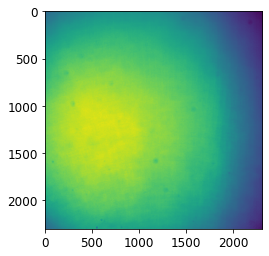

In [6]:
illumprof = io.imread('20210804_Station10_488_illum_prof.tif')
illumprof = skimage.filters.gaussian(illumprof.astype('float'))
illumprof = illumprof-darknoise
illumprof = illumprof/illumprof.max()
plt.imshow(illumprof)

In [7]:
io.imsave('20210804_Station10_488_illum_prof_corrected.png',illumprof)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [8]:
impths = glob.glob(os.path.join(raw_image_dir,'*/*.tif'))
segpths = glob.glob(os.path.join(analysis_dir,'*/segm/*.png'))

In [9]:
# For Station 1/Metamorph
# comp = re.compile('Well(?P<Well>\d+)_w\dtae\s(?P<Channel>\w+)_s(?P<Pos>\d+)')

# For Station 10/Elements
comp = re.compile('Well(?P<Well>\d+)_XY(?P<Pos>\d+)_Confocal\s(?P<Channel>\d+)')

In [10]:
dict_list = []

for pth in impths:
    timing = pth.split('/')[-2]
    fname = os.path.basename(pth)
    
    d = comp.match(fname).groupdict()
    d['Filename'] = fname
    d['Path'] = pth
    d['Timing'] = timing
    
    dict_list.append(d)
    
df_meta = pd.DataFrame(dict_list)
df_meta[['Well','Pos']] = df_meta[['Well','Pos']].astype(int)
df_meta.sort_values(['Timing','Well','Pos','Channel'],inplace=True)
df_meta.head()


,Well,Pos,Channel,Filename,Path,Timing
21,1,1,488,Well1_XY1_Confocal 488.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,After_washin
37,1,1,640,Well1_XY1_Confocal 640.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,After_washin
42,1,2,488,Well1_XY2_Confocal 488.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,After_washin
26,1,2,640,Well1_XY2_Confocal 640.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,After_washin
60,1,3,488,Well1_XY3_Confocal 488.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,After_washin


In [11]:
dict_list = []

for pth in segpths:
    timing = pth.split('/')[-3]
    fname = os.path.basename(pth)
    
    d = comp.match(fname).groupdict()
    d['Filename'] = fname
    d['Path'] = pth
    d['Timing'] = timing
    
    dict_list.append(d)
    
df_meta_seg = pd.DataFrame(dict_list)
df_meta_seg[['Well','Pos']] = df_meta_seg[['Well','Pos']].astype(int)
df_meta_seg.sort_values(['Timing','Well','Pos','Channel'],inplace=True)
df_meta_seg.head()


,Well,Pos,Channel,Filename,Path,Timing
33,1,1,640,Well1_XY1_Confocal 640.png,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin
5,1,2,640,Well1_XY2_Confocal 640.png,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin
17,1,3,640,Well1_XY3_Confocal 640.png,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin
21,1,4,640,Well1_XY4_Confocal 640.png,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin
31,1,5,640,Well1_XY5_Confocal 640.png,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin


In [12]:
df_meta['Concentration'] = [well_conc_map[w] for w in df_meta['Well']]

In [13]:
df_meta_combined = df_meta.merge(df_meta_seg,on=['Well','Channel','Pos','Timing'],suffixes=('_im','_seg'),how='left')
df_meta_combined

,Well,Pos,Channel,Filename_im,Path_im,Timing,Concentration,Filename_seg,Path_seg
0,1,1,488,Well1_XY1_Confocal 488.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,After_washin,5.0,NaN,NaN
1,1,1,640,Well1_XY1_Confocal 640.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,After_washin,5.0,Well1_XY1_Confocal 640.png,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...
2,1,2,488,Well1_XY2_Confocal 488.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,After_washin,5.0,NaN,NaN
3,1,2,640,Well1_XY2_Confocal 640.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,After_washin,5.0,Well1_XY2_Confocal 640.png,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...
4,1,3,488,Well1_XY3_Confocal 488.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,After_washin,5.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
139,6,4,640,Well6_XY4_Confocal 640.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,Before_washin,0.0,Well6_XY4_Confocal 640.png,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...
140,6,5,488,Well6_XY5_Confocal 488.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,Before_washin,0.0,NaN,NaN
141,6,5,640,Well6_XY5_Confocal 640.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,Before_washin,0.0,Well6_XY5_Confocal 640.png,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...
142,6,6,488,Well6_XY6_Confocal 488.tif,/Users/tyyoo/MitchisonLab/Data/SpinningDisk_IF...,Before_washin,0.0,NaN,NaN


In [14]:
df_data = pd.DataFrame()

for ind,df in df_meta_combined.groupby(['Well','Timing','Pos']):
    well,timing,pos = ind
    
    seg = -99
    
    ims = {}
    props_dict = {}
    
    for i,row in df.iterrows():
        ch = row['Channel']
        fname_im = row['Filename_im']
        pth_im = row['Path_im']
        pth_seg = row['Path_seg']
                
        if ch==seg_ch:
            seg = io.imread(pth_seg)
        
        im = io.imread(pth_im)
        
        if ch=='488':
            im = im.astype('float')-darknoise
            im = im/illumprof #illumination uneveness correction
        
        ims[ch] = im

    
    if 'binning_factor' not in locals():
        binning_factor = int(ims[seg_ch].shape[0]/seg.shape[0])
    
    for ch in ims:
        ims[ch] = downsample(ims[ch],binning_factor)
        
        props_dict[ch] = measure.regionprops(seg,intensity_image=ims[ch])
        
    newlist = []
    for j,p_nucl in enumerate(props_dict[seg_ch]):
        #nucleus dimensions
        cent = p_nucl.centroid
        orientation = p_nucl.orientation
        area = p_nucl.area
        eccen = p_nucl.eccentricity
        perimeter = p_nucl.perimeter
        
        newdict = {'Path_seg':pth_seg,'Timing':timing,'Well':well,
                   'Pos':pos,'ID':p_nucl.label,
                   'cent_x':cent[1],'cent_y':cent[0],
                   'orientation':orientation,'area':area,
                   'perimeter':perimeter,'eccen':eccen}
        
        # add channel-specific properties to newdict
        for ch in props_dict:
            props = props_dict[ch]
            p = props[j]
            
            intim = p.intensity_image
            
            newdict['meanint_'+ch] = p.mean_intensity
            newdict['maxint_'+ch] = p.max_intensity
            newdict['minint_'+ch] = p.min_intensity
            newdict['stdint_'+ch] = np.std(intim[intim>0])
        
        newlist.append(newdict)
    
    df_data = pd.concat((df_data,pd.DataFrame(newlist)))
    
df_data = df_data.reset_index(drop=True)

In [15]:
df_data

,Path_seg,Timing,Well,Pos,ID,cent_x,cent_y,orientation,area,perimeter,eccen,meanint_488,maxint_488,minint_488,stdint_488,meanint_640,maxint_640,minint_640,stdint_640
0,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,1,10.529412,1.470588,-1.460207,51,30.449747,0.949789,2134.054962,2354.311796,1897.966147,97.400198,436.970588,621.75,321.50,70.204771
1,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,2,131.735751,5.427461,1.438054,386,87.213203,0.922632,2273.952391,2542.048062,1991.256120,97.949353,536.772021,696.50,320.00,74.252055
2,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,4,170.573964,3.822485,1.495076,169,53.313708,0.866871,2205.474985,2513.180247,1968.547210,92.254629,732.594675,954.75,425.75,91.318449
3,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,5,215.759596,12.915152,0.008866,495,86.041631,0.736273,2015.196154,2333.436873,1783.299550,97.705583,502.253535,721.00,292.00,84.744647
4,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,6,310.658863,6.521739,1.148649,299,69.213203,0.804751,2067.046561,2334.212426,1859.292493,98.161156,530.578595,724.50,285.75,85.575448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,Before_washin,6,6,248,803.403008,1136.681203,-1.228300,665,102.426407,0.852417,3.594329,18.157533,-8.749186,3.263809,325.894737,450.50,170.75,52.611906
13024,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,Before_washin,6,6,250,166.336000,1132.888000,-0.815309,125,40.142136,0.596076,57.064475,97.115717,29.955372,13.990248,196.326000,275.75,151.50,25.369435
13025,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,Before_washin,6,6,251,289.516667,1146.933333,1.191443,120,40.727922,0.783581,1.657119,14.829980,-9.148414,3.803201,758.804167,888.75,500.75,75.156851
13026,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,Before_washin,6,6,253,595.275000,1146.400000,0.167498,40,21.656854,0.717703,125.370672,166.859646,63.951742,25.753782,221.737500,253.50,181.50,20.398602


In [16]:
df_data['T'] = (df_data['Timing']=='After_washin').astype('int')

In [17]:
for ind,df in df_data.groupby(['Well','Pos']):
    well,pos = ind
    new_df = tp.link(df,search_range=10,pos_columns=['cent_x','cent_y'],t_column='T')
    
    df_data.loc[new_df.index,'ID'] = new_df['particle']

Frame 1: 152 trajectories present.


In [18]:
# background intensity determination
dict_list = []
for ind,df in df_meta_combined.loc[df_meta_combined['Channel']=='488'].groupby(['Well','Timing']):
    well,timing = ind
    
    ims = []
    
    for i,row in df.iterrows():
        pth_im = row['Path_im']
                
        im = io.imread(pth_im)
        im = im.astype('float')-darknoise
        im = im/illumprof #illumination uneveness correction

        ims.append(im)
    
    dict_list.append({'Well':well,'Timing':timing,'bg_488':get_bg(ims)})
    
df_bg = pd.DataFrame(dict_list)


In [19]:
df_bg

,Well,Timing,bg_488
0,1,After_washin,2062.085456
1,1,Before_washin,0.282124
2,2,After_washin,952.468901
3,2,Before_washin,0.322751
4,3,After_washin,543.245958
5,3,Before_washin,0.280201
6,4,After_washin,262.616195
7,4,Before_washin,0.310219
8,5,After_washin,135.981817
9,5,Before_washin,0.287746


In [20]:
df_data = df_data.merge(df_bg,how='outer',on=['Well','Timing'])

In [21]:
df_data.head()

,Path_seg,Timing,Well,Pos,ID,cent_x,cent_y,orientation,area,perimeter,...,meanint_488,maxint_488,minint_488,stdint_488,meanint_640,maxint_640,minint_640,stdint_640,T,bg_488
0,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,219,10.529412,1.470588,-1.460207,51,30.449747,...,2134.054962,2354.311796,1897.966147,97.400198,436.970588,621.75,321.50,70.204771,1,2062.085456
1,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,218,131.735751,5.427461,1.438054,386,87.213203,...,2273.952391,2542.048062,1991.256120,97.949353,536.772021,696.50,320.00,74.252055,1,2062.085456
2,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,0,170.573964,3.822485,1.495076,169,53.313708,...,2205.474985,2513.180247,1968.547210,92.254629,732.594675,954.75,425.75,91.318449,1,2062.085456
3,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,107,215.759596,12.915152,0.008866,495,86.041631,...,2015.196154,2333.436873,1783.299550,97.705583,502.253535,721.00,292.00,84.744647,1,2062.085456
4,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,77,310.658863,6.521739,1.148649,299,69.213203,...,2067.046561,2334.212426,1859.292493,98.161156,530.578595,724.50,285.75,85.575448,1,2062.085456


In [22]:
df_data['meanint_488_sub'] = df_data['meanint_488']-df_data['bg_488']

In [23]:
df_sidebyside = df_data.loc[df_data['Timing']=='After_washin'].merge(df_data.loc[df_data['Timing']=='Before_washin'],
                                                                     on=['Well','Pos','ID'],how='inner',
                                                                     suffixes=('_a','_b'))
df_sidebyside.head()

,Path_seg_a,Timing_a,Well,Pos,ID,cent_x_a,cent_y_a,orientation_a,area_a,perimeter_a,...,maxint_488_b,minint_488_b,stdint_488_b,meanint_640_b,maxint_640_b,minint_640_b,stdint_640_b,T_b,bg_488_b,meanint_488_sub_b
0,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,218,131.735751,5.427461,1.438054,386,87.213203,...,24.131604,-14.064405,3.361676,509.653000,659.25,336.00,57.947289,0,0.282124,-1.199587
1,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,0,170.573964,3.822485,1.495076,169,53.313708,...,12.705627,-12.230494,2.992453,722.478659,830.25,517.00,64.804587,0,0.282124,-0.032453
2,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,107,215.759596,12.915152,0.008866,495,86.041631,...,16.695523,-12.522240,3.118599,442.285714,601.50,270.50,68.712914,0,0.282124,-1.021591
3,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,77,310.658863,6.521739,1.148649,299,69.213203,...,15.209432,-15.987984,3.108734,469.637615,619.00,291.75,64.050922,0,0.282124,-1.614815
4,/Users/tyyoo/MitchisonLab/analysis/unet4nuclei...,After_washin,1,1,76,366.650704,8.777465,0.844388,355,72.284271,...,438.111065,203.551034,51.248733,538.905172,705.75,303.75,81.301703,0,0.282124,332.464227


In [24]:
df_sidebyside['meanint_488_b'] = df_sidebyside['meanint_488_b']-df_sidebyside['meanint_488_b'].min()

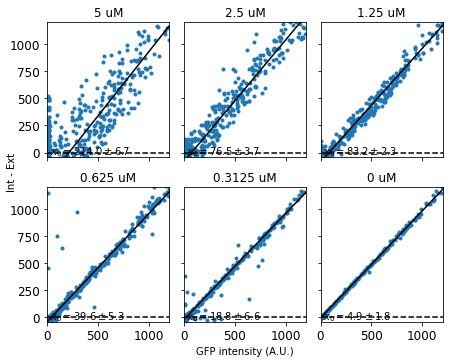

In [25]:
fig,axes = plt.subplots(figsize=(7,5.5),nrows=2,ncols=3,sharex=True,sharey=True)

axes = axes.flatten()
i = 0

concs = []
x0s = []
dx0s = []

for ind,df in df_sidebyside.groupby('Well'):
    ax = axes[i]
    
    df = df.loc[df['area_b']>100]
    ax.plot(df['meanint_488_b'],df['meanint_488_sub_a'],'.')
    
    p,pcov = curve_fit(lambda x,a,x0:a*(x-x0),df['meanint_488_b'],df['meanint_488_sub_a'])
    #p = np.polyfit(df['meanint_447_b'],df['meanint_447_sub_a'],deg=1)
    
    xx = np.linspace(0,1200)
    yy = p[0]*(xx-p[1])
    ax.plot(xx,yy,'k')
    
    ax.text(25,-20,'$x_0=%0.1f\pm%0.1f$' %(p[1],np.sqrt(pcov[1,1])))

    ax.set_xlim([0,1200])
    ax.set_ylim([-40,1200])
    ax.set_title(str(well_conc_map[ind])+' uM')
    
    concs.append(well_conc_map[ind])
    x0s.append(p[1])
    dx0s.append(np.sqrt(pcov[1,1]))
    
    ax.axhline(y=0,ls='--',c='k')
    
    i += 1

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('GFP intensity (A.U.)')
plt.ylabel('Int - Ext')

plt.tight_layout()

fig.savefig(savename+'_scatterplots.pdf')

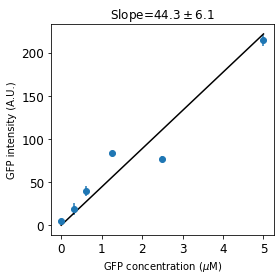

In [26]:
fig = plt.figure(figsize=(4,4))

p,pcov = curve_fit(lambda x,a:a*x,concs,x0s,sigma=dx0s)
    
plt.errorbar(concs,x0s,yerr=dx0s,fmt='o')

xx = np.linspace(0,np.max(concs))
yy = p[0]*xx

plt.plot(xx,yy,'k')

plt.xlabel('GFP concentration ($\mu$M)')
plt.ylabel('GFP intensity (A.U.)')

plt.title('Slope=$%0.1f \pm %0.1f$' %(p[0],np.sqrt(pcov[0])))

plt.tight_layout()

fig.savefig(savename+'_calib_res.pdf')